<h1 align="center">OpenMP part 2</h1> 

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [2]:
# write your code here
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
from pyccel.epyccel import epyccel
import time

In [20]:
%%file nonlinearconv2d.py
from pyccel.stdlib.internal.openmp import omp_in_parallel,omp_get_thread_num, omp_get_num_threads

def threads_num():
    #getting threads num
    n = omp_get_num_threads()
    return n 
def solve_2d_nonlinearconv(u : 'float[:]', un : 'float[:]', v : 'float[:]', vn : 'float[:]',nt : int,dt : float, dx : float, dy : float, c : float):
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    
    #fill the update of u and v
    for n in range(nt + 1): ##loop across number of time steps
        un = u.copy()
        vn = v.copy()

        u[1:, 1:] = (un[1:, 1:] - 	
                     (un[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[:-1, 1:])) -
                      vn[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[1:, :-1]))
        v[1:, 1:] = (vn[1:, 1:] -
                     (un[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[:-1:, 1:])) -
                     vn[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[1:, :-1]))
        #boundary conditions
        u[0, :] = 1
        u[-1, :] = 1
        u[:, 0] = 1
        u[:, -1] = 1

        v[0, :] = 1
        v[-1, :] = 1
        v[:, 0] = 1
        v[:, -1] = 1

    return 0

Overwriting nonlinearconv2d.py


In [33]:
#%%file conv_test.py
def non_linear_convection(nt : int, nx : int, ny : int, tmax : float, xmax : float, ymax : float):
   """
   Returns the velocity field and distance for 2D linear convection
   """
   # Increments
   dt = tmax/(nt-1)
   dx = xmax/(nx-1)
   dy = ymax/(ny-1)

   # Initialise data structures
   import numpy as np
   u = np.zeros(((nx,ny,nt)))
   v = np.zeros(((nx,ny,nt)))
   x = np.zeros(nx)
   y = np.zeros(ny)

   # Boundary conditions
   u[0,:,:] = u[nx-1,:,:] = u[:,0,:] = u[:,ny-1,:] = 1
   v[0,:,:] = v[nx-1,:,:] = v[:,0,:] = v[:,ny-1,:] = 1

   # Initial conditions
   u[:,:,:] = v[:,:,:] = 1
   u[int((nx-1)/4):int((nx-1)/2),int((ny-1)/4):int((ny-1)/2),0] = 2
   v[int((nx-1)/4):int((nx-1)/2),int((ny-1)/4):int((ny-1)/2),0] = 2

   # Loop
   for n in range(0,nt-1):
      for i in range(1,nx-1):
         for j in range(1,ny-1):
            u[i,j,n+1] = (u[i,j,n]-dt*((u[i,j,n]/dx)*(u[i,j,n]-u[i-1,j,n])+
                                       (v[i,j,n]/dy)*(u[i,j,n]-u[i,j-1,n])))
            v[i,j,n+1] = (v[i,j,n]-dt*((u[i,j,n]/dx)*(v[i,j,n]-v[i-1,j,n])+
                                       (v[i,j,n]/dy)*(v[i,j,n]-v[i,j-1,n])))

   # X Loop
   for i in range(0,nx):
      x[i] = i*dx

   # Y Loop
   for j in range(0,ny):
      y[j] = j*dy

   return u, v, x, y

In [35]:
%%file test_con.py
if __name__ == '__main__':
    import time
    from conv_test import non_linear_convection
    
    # Start timing
    tcpu_0 = time.process_time() # CPU time
    u,v,x,y = non_linear_convection(101, 81, 81, 0.5, 2.0, 2.0)
    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0
    print("cpu time is ",tcpu)


Overwriting test_con.py


/home/zineb/Documents/Al-Khwarizmi-HPC-Programming/v_en/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


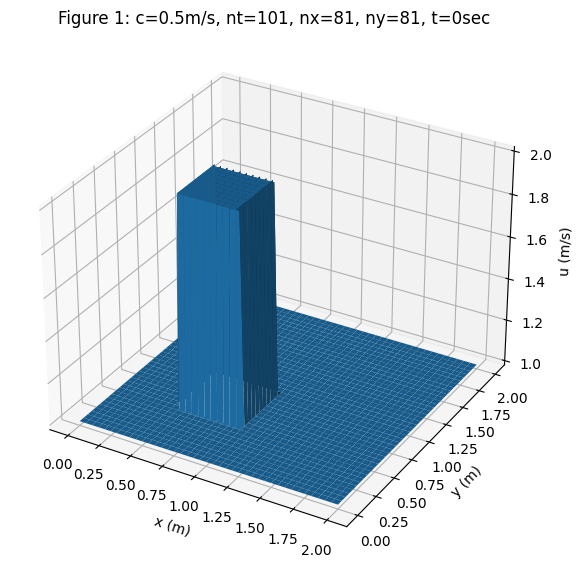

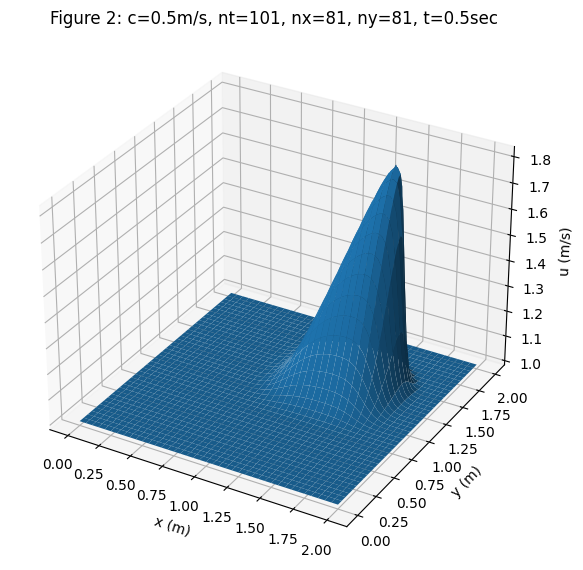

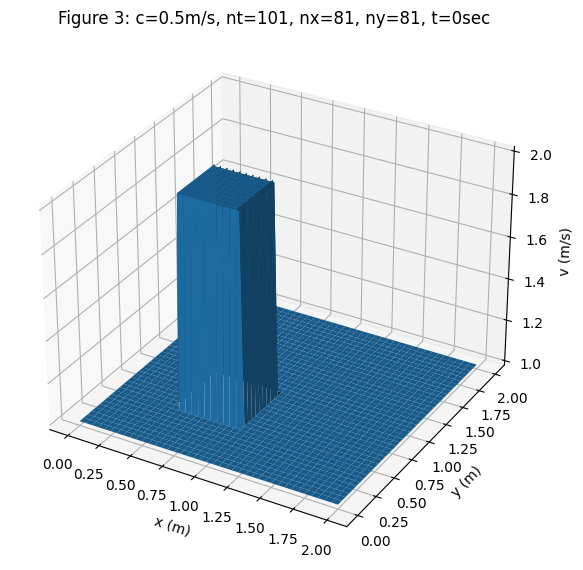

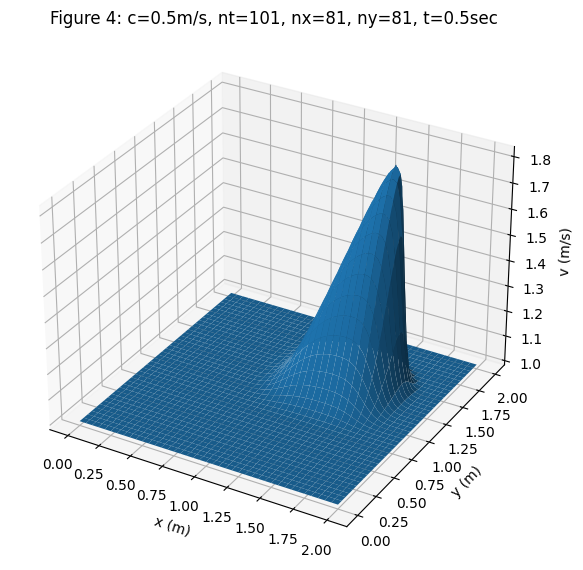

In [29]:
u,v,x,y = non_linear_convection(101, 81, 81, 0.5, 2.0, 2.0)

plot_3D(u,x,y,0,'Figure 1: c=0.5m/s, nt=101, nx=81, ny=81, t=0sec','u (m/s)')
plot_3D(u,x,y,100,'Figure 2: c=0.5m/s, nt=101, nx=81, ny=81, t=0.5sec','u (m/s)')
plot_3D(v,x,y,0,'Figure 3: c=0.5m/s, nt=101, nx=81, ny=81, t=0sec','v (m/s)')
plot_3D(v,x,y,100,'Figure 4: c=0.5m/s, nt=101, nx=81, ny=81, t=0.5sec','v (m/s)')

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [1]:
# write your code here